In [1]:
import pickle
import os
import numpy as np
import mdtraj
import deeptime
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from collections import defaultdict
from westpa_helpers import *

In [2]:
FPS=10 # FPS for movie
protein_name = "trpcage"
iterative_display = False

In [3]:
current_directory = os.getcwd()

In [4]:
# Change this to the root of the run
# home_path=f"/media/DATA_18_TB_1/awaghili/WESTPA_MM/mabbin_{protein_name}_manual_binning/westpa_prop"
home_path=f"/media/DATA_18_TB_1/awaghili/WESTPA_MM/mabbin_{protein_name}_2/westpa_prop"
os.chdir(home_path)

sim_config = extract_all_atom_simulation_config()


# Will be needed to unpickle the TICA models
import sys
sys.path.append(sim_config['cgschnet_path'])

In [5]:
# Define any additional coordinate files, such as the ground truth
coordinate_files = [
    f"/media/DATA_14_TB/daniel_s/cg_all_benchmark_finetuneE01_s4/{protein_name}*/raw/coordinates.npy",
]

In [6]:
topology = mdtraj.load(sim_config['topology_path']).topology
traj_dirs = sorted(glob.glob(f"./traj_segs/*/*"))
merged_name = f"combined_trajs/{protein_name}"

ca_indices = [atom.index for atom in topology.atoms if atom.name == 'CA']


# Group trajectories by iteration
iteration_groups = defaultdict(list)
for td in traj_dirs:
    parts = td.split(os.sep)
    iteration = parts[-2]  # assuming path: traj_segs/iteration#/segment#
    iteration_groups[iteration].append(td)


# Cumulative storage
cumulative_traj = []

# Loop through sorted iterations
for i, iteration in tqdm(enumerate(sorted(iteration_groups.keys()))):
    for td in iteration_groups[iteration]:
        dcd_path = os.path.join(td, "seg.dcd")
        if not os.path.isfile(dcd_path):
            print(f"Missing file: {dcd_path}")
            continue
        try:
            traj = mdtraj.load(dcd_path, top=topology)
            traj_ca = traj.atom_slice(ca_indices)
            cumulative_traj.append(traj_ca)
        except Exception as e:
            print(f"Error loading {dcd_path}")
            print(e)
            continue

    # Save cumulative trajectory at this iteration
    if iterative_display:
        merged_traj = cumulative_traj[0].join(cumulative_traj[1:]) if len(cumulative_traj) > 1 else cumulative_traj[0]
        merged_traj.save_hdf5(f"{merged_name}_{i}.h5")

# Final save of the fully cumulative trajectory
if cumulative_traj:
    merged_traj = cumulative_traj[0].join(cumulative_traj[1:]) if len(cumulative_traj) > 1 else cumulative_traj[0]
    merged_traj.save_hdf5(merged_name + "_all.h5")
    print("Saved cumulative trajectory to:", merged_name + "_all.h5")

1042it [08:26,  2.06it/s]


Saved cumulative trajectory to: combined_trajs/trpcage_all.h5


In [7]:
import re

def extract_number(filename):
    match = re.search(fr'{protein_name}_(\d+)\.h5', filename)
    return int(match.group(1)) if match else float('inf') 

if iterative_display:
    # Expand the glob pattern into a list
    expanded_files = sorted(glob.glob(
        home_path + "/combined_trajs/*.h5" #Change this to *_all.h5 if you only want the final result
    ), key=extract_number)
else:
    expanded_files = sorted(glob.glob(
        home_path + "/combined_trajs/*_all.h5" #Change this to *_all.h5 if you only want the final result
    ), key=extract_number)
    

# Append the matched files to the coordinate_files list
coordinate_files.extend(expanded_files)

In [8]:
model = load_tica_model(sim_config["tica_model_path"])
coordinate_list, label_list = load_trajectories(coordinate_files, size_limit=1000000)

/home/md-ml/miniconda3/envs/andy-reports-3/lib/python3.11/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator CovarianceModel from version 0.4.5 when using version 0.4.4. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/md-ml/miniconda3/envs/andy-reports-3/lib/python3.11/site-packages/deeptime/base.py:116: UserWarning: Trying to unpickle estimator CovarianceKoopmanModel from version 0.4.5 when using version 0.4.4. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/home/md-ml/miniconda3/envs/andy-reports-3/lib/python3.11/site-packages/mdtraj/core/trajectory.py:441: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn("top= kwargs ignored since this file parser does not support it")

100%|██████████| 2/2 [00:27<00:00, 13.59s/it]


In [9]:
components_to_calculate = range(2) # Number of components to calculate
tica_plot_pad = 0.2

kB = 0.0019872041 # kcal/mol/Kelvin
Temp = 300 # Kelvin

In [10]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

def wrapper(args):
    model, c, components_to_calculate = args
    return calculate_component_values(model, c, components_to_calculate)

# Prepare arguments as a list of tuples
args_list = [(model, c, components_to_calculate) for c in tqdm(coordinate_list)]

# Run in parallel
with ProcessPoolExecutor(max_workers=100) as executor:
    component_values = list(tqdm(executor.map(wrapper, args_list), total=len(coordinate_list)))

component_values[0].keys(), [[len(v) for v in c.values()] for c in component_values]

component_maxs = [max([max(c[tica_comp]) for c in component_values]) for tica_comp in components_to_calculate]
component_mins = [min([min(c[tica_comp]) for c in component_values]) for tica_comp in components_to_calculate]
component_range = [*zip(component_mins, component_maxs)]

100%|██████████| 2/2 [00:23<00:00, 11.64s/it]


In [11]:
histogram_range = np.array([[component_range[0][0] - tica_plot_pad, component_range[0][1] + tica_plot_pad],
                            [component_range[1][0] - tica_plot_pad, component_range[1][1] + tica_plot_pad]])
num_contour_levels = 6

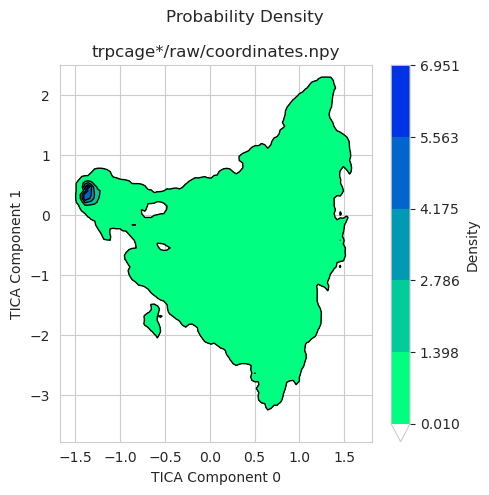

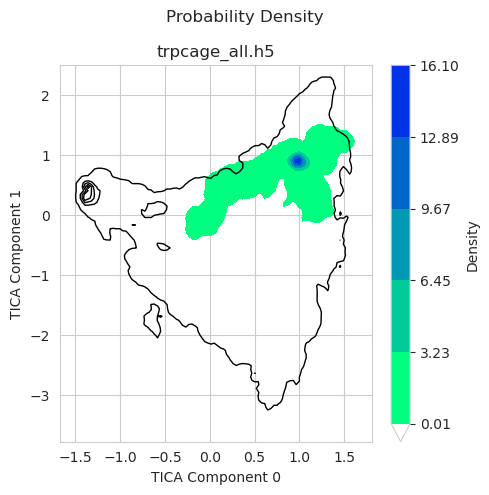

In [12]:
for i in range(len(coordinate_list)):
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a new figure for each plot

    hist2d, xedges, yedges = np.histogram2d(
        component_values[i][0],
        component_values[i][1],
        bins=(100, 100),
        range=histogram_range,
        density=True,
    )

    max_density = np.max(hist2d)
    if max_density <= 0.01:
        levels = np.linspace(0.001, 0.01, num_contour_levels)
    else:
        levels = np.linspace(0.01, round(max_density * 1.1, 3), num_contour_levels)

    if i == 0:
        hist_ref = hist2d
        levels_ref = levels

    contour = ax.contourf(
        hist2d.T,
        origin='lower',
        extent=histogram_range.flatten(),
        levels=levels,
        extend='min',
        colors=[(0.0, 0.0, 0.0, 0.0)] + [plt.cm.winter_r(j / (len(levels) - 1)) for j in range(len(levels) - 1)],
    )

    ax.contour(
        hist_ref.T,
        origin='lower',
        extent=histogram_range.flatten(),
        levels=levels_ref,
        colors="black",
        linewidths=1,
        linestyles="-"
    )

    ax.set_xlabel('TICA Component 0')
    ax.set_ylabel('TICA Component 1')
    fig.colorbar(contour, ax=ax, label='Density')
    ax.set_title(shorten_label(label_list[i], 50))

    fig.suptitle("Probability Density")
    plt.tight_layout()
    plt.show()


In [ ]:
# Movie

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(5, 5))

# Prepare the first frame manually
hist_ref = None
levels_ref = None

# Store all 2D histograms and levels ahead of time
histograms = []
levels_list = []

for i in range(len(coordinate_list)):
    hist2d, xedges, yedges = np.histogram2d(
        component_values[i][0],
        component_values[i][1],
        bins=(100, 100),
        range=histogram_range,
        density=True,
    )

    max_density = np.max(hist2d)
    if max_density <= 0.01:
        levels = np.linspace(0.001, 0.01, num_contour_levels)
    else:
        levels = np.linspace(0.01, round(max_density * 1.1, 3), num_contour_levels)

    histograms.append(hist2d)
    levels_list.append(levels)

    if i == 0:
        hist_ref = hist2d
        levels_ref = levels

# Function to update the frame
def update(i):
    ax.clear()

    hist2d = histograms[i]
    levels = levels_list[i]

    contour = ax.contourf(
        hist2d.T,
        origin='lower',
        extent=histogram_range.flatten(),
        levels=levels,
        extend='min',
        colors=[(0.0, 0.0, 0.0, 0.0)] + [plt.cm.winter_r(j / (len(levels) - 1)) for j in range(len(levels) - 1)],
    )

    ax.contour(
        hist_ref.T,
        origin='lower',
        extent=histogram_range.flatten(),
        levels=levels_ref,
        colors="black",
        linewidths=1,
        linestyles="-"
    )

    ax.set_xlabel('TICA Component 0')
    ax.set_ylabel('TICA Component 1')
    ax.set_title(shorten_label(label_list[i], 50))
    fig.suptitle("Probability Density")
    return contour.collections

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=len(coordinate_list), blit=False
)

print(current_directory)
# Save animation to file
ani.save(current_directory + "/density_movie.mp4", writer='ffmpeg', fps=FPS)  # Adjust `fps` as needed


2025-06-17 23:47:31,483 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-06-17 23:47:31,484 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 500x500 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/md-ml/awaghili/cgschnet/cgschnet/scripts/westpa_analysis/density_movie.mp4


/home/md-ml/awaghili/cgschnet/cgschnet/scripts/westpa_analysis


/tmp/ipykernel_598505/2464068513.py:69: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  return contour.collections


In [ ]:
histogram_range = np.array([[component_range[0][0] - tica_plot_pad, component_range[0][1] + tica_plot_pad],
                            [component_range[1][0] - tica_plot_pad, component_range[1][1] + tica_plot_pad]])
num_contour_levels = 6

# TODO: Use grid function from bond/angle notebook
fig, axes = plt.subplots(1, len(coordinate_list), figsize=(5*len(coordinate_list), 5))
if len(coordinate_list) == 1:
    axes = [axes]
hist_ref = None
levels_ref = None

for i in range(len(coordinate_list)):
    hist2d, xedges, yedges = np.histogram2d(
        component_values[i][0],
        component_values[i][1],
        bins=(100, 100),
        range=histogram_range,
        density=True,
    )

#     levels = np.linspace(0.01, round(np.max(hist2d)*1.1, 1), num_contour_levels)

    max_density = np.max(hist2d)
    if max_density <= 0.01:
        levels = np.linspace(0.001, 0.01, num_contour_levels)  # fallback for low density
    else:
        levels = np.linspace(0.01, round(max_density * 1.1, 3), num_contour_levels)

    if hist_ref is None:
        hist_ref = hist2d
        levels_ref = levels


    contour1 = axes[i].contourf(hist2d.T, origin='lower', extent=histogram_range.flatten(), levels=levels, extend='min',
                                colors=[(0.0,0.0,0.0,0.0)]+[plt.cm.winter_r(i/(len(levels)-1)) for i in range(len(levels)-1)])
    axes[i].contour(hist_ref.T, origin='lower', extent=histogram_range.flatten(), levels=levels_ref, colors="black", linewidths=1, linestyles="-")
    axes[i].set_xlabel('TICA Component 0')
    axes[i].set_ylabel('TICA Component 1')
    fig.colorbar(contour1, ax=axes[i], label='Density')
    axes[i].set_title(shorten_label(label_list[i], 50))

fig.suptitle("Proability density")
plt.tight_layout()
plt.show()


In [ ]:

# TODO: Use grid function from bond/angle notebook
fig, axes = plt.subplots(1, len(coordinate_list), figsize=(5*len(coordinate_list), 5))
if len(coordinate_list) == 1:
    axes = [axes]
hist_ref = None

for i in range(len(coordinate_list)):
    hist2d, xedges, yedges = np.histogram2d(
        component_values[i][0],
        component_values[i][1],
        bins=(100, 100),
        range=histogram_range,
    )

    hist_log_mask = hist2d > 0
    hist2d[hist_log_mask] = -kB * Temp * np.log(hist2d[hist2d > 0])
    hist2d[~hist_log_mask] = 0.0000001 # The histograms look nicer if the undefined values are slightly more than zero

    levels=np.linspace(round(np.min(hist2d)*1.1, 1), 0, num_contour_levels)

    if hist_ref is None:
        hist_ref = hist2d
        levels_ref = levels

    contour1 = axes[i].contourf(hist2d.T, origin='lower', extent=histogram_range.flatten(), levels=levels, extend='max',
                                colors=[plt.cm.winter_r(i/(len(levels)-1)) for i in range(len(levels)-1)]+[(0.0,0.0,0.0,0.0)])
    axes[i].contour(hist_ref.T, origin='lower', extent=histogram_range.flatten(), levels=levels_ref, colors="black", linewidths=1, linestyles="-")
    axes[i].set_xlabel('TICA Component 0')
    axes[i].set_ylabel('TICA Component 1')
    fig.colorbar(contour1, ax=axes[i], label='Free energy (kca/mol)')
    axes[i].set_title(shorten_label(label_list[i], 50))

plt.tight_layout()
plt.show()
